# One-shot Learning and Omniglot

The one-shot classification task involves trying to categorize new data based on limited experience, which is something that humans excel at.  A somewhat trite example is the fact that children are able to accurately categorize new objects based on very limited experience; For instance, show a child a single picture of a giraffe and they will most likely be able to accurately categorize future pictures of giraffes.

Advances in neural network and computer architecture have combined with accessible software packages to allow for the creation very powerful image and speech recognition models. While this has led to awesome technological advances, these models are often very task specific and require huge amounts of data to train.

Nevertheless, there remain many domains where accurate classification is required but limited data is available. Because of this, finding reliable methods for designing and training machine learning models which display the ability to *learn* from limited experience, as children do, and perform well in these situations is an important area of research.

### Omniglot Dataset

A great example of a dataset where limited examples are available is the [Omniglot dataset](https://github.com/brendenlake/omniglot). This dataset consists of images of 1623 different characters spanning 50 alphabets, with 20 examples of each character (each example having been drawn by a different person).  Because of the fact that this dataset contains a huge number of classes with relatively few examples, it has become colloquially known as the *inverse* of the famous [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which, by contrast contains a large number of examples of relatively few characters (hand drawn images of the numbers 0 through 9).


### Classification Task

The omniglot dataset has been split into two parts; a background set consisting of 30 alphabets and an evaluation set consisting of 20 alphabets.  The task is to learn models on the background set (which consists of entirely different alphabets from those in the evaluation set) and use these to make 20-way one-shot predictions on the evaluation set.
That last sentence is a bit loaded with jargon, so let's spend some time unpacking it.  

The image below provides an example of an instance of a 25-way one-shot classification task from the omniglot dataset.  

![oneshot task](../reports/figures/task_25.png)

We are given a *test image* and provided with 20 examples (which are called the *support set* and is where the 20-way comes from).  These examples represent our limited experience (together with whatever model we have trained on the background set) and it is guaranteed that the test image is of the same character type as exactly one of the 20 examples.  The goal is to accurately pick which one.   

As outlined in [Siamese Neural Networks for One-shot Image Recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) by Koch et. al., to evaluate this task:
 - An alphabet is chosen from among the evaluation set.
 - 20 characters are sampled without replacement from the alphabet.
 - Two of the 20 drawers are chosen at random. 
 - The 20 characters of one drawer are assigned to the test set while those of the other are assigned to the support set. 
 - For a given model, for each member of the test set we use our model to predict which member of the support set has the same class. 
 - We can then compare these predictions against the known classes of the test members and use the number of correct classifications to estimate how accurate our model is.
 - repeating this for a large number of such randomly generated tasks should, by the law of large numbers, give us a decent estimate of the accuracy of our model at 20-way one-shot classification tasks. 
 

# Initial Exploration of the Dataset

The [raw data](https://github.com/brendenlake/omniglot/tree/master/python) was processed and saved to separate numpy arrays containing image pixels and category information.  This was handled by the script `/src/data/make_dataset.py` in this repository.  

In [1]:
import numpy as np
import pandas as pd

# Set seed
np.random.seed(0)

# Load the background dataset. X_background contains the background
# images and y_background class information.
train_npz_file = np.load('../data/processed/train.npz')
X_background, y_background = train_npz_file['arr_0'], train_npz_file['arr_1']

# Load the evaluation dataset. X_evaluation contains the background
# images and y_evaluation class information.
test_npz_file = np.load('../data/processed/test.npz')
X_evaluation, y_evaluation = test_npz_file['arr_0'], test_npz_file['arr_1']

# Put the class information in pandas arrays for ease of exploration
# and constrained sampling.  
y_background_pd = pd.DataFrame(
                    data=y_background, 
                    columns=['Alphabet', 'Character', 'Drawer']
    )
y_evaluation_pd = pd.DataFrame(
                    data=y_evaluation, 
                    columns=['Alphabet', 'Character', 'Drawer']
    )

# Check shapes of images.
print(X_background.shape, y_background.shape, X_evaluation.shape, y_evaluation.shape)

(19280, 105, 105) (19280, 3) (13180, 105, 105) (13180, 3)


We can get a grip on the specifics of the dataset by looking at some queries from the dataframes.  Let's make sure that the basic info above is matched by what we loaded in:

In [3]:
# Number of alphabets in the background and evaluation sets
n_b_al = y_background_pd.Alphabet.unique().shape[0]
n_e_al = y_evaluation_pd.Alphabet.unique().shape[0]
print('There are {} alphabets in the background set and {} in the evaluation set.'.format(
                            n_b_al, n_e_al
))
print('This gives a total of {} alphabets in the dataset.'.format(
                            n_b_al + n_e_al
), '\n')


# Number of characters in the background and evaluation sets
n_b_ch = y_background_pd.groupby(['Alphabet', 'Character']).max().shape[0]
n_e_ch = y_evaluation_pd.groupby(['Alphabet', 'Character']).max().shape[0]
print('There are {} characters in the background set and {} in the evaluation set.'.format(
                            n_b_ch, n_e_ch
))
print('This gives a total of {} characters in the dataset.'.format(
                            n_b_ch + n_e_ch
), '\n')

# Check that the number of drawers is the same in each set and
# find the total number of characters
n_drawers_b = y_background_pd.Drawer.unique().shape[0]
min_max_b = y_background_pd.groupby(['Alphabet', 'Character']).max().min().values[0]
n_drawers_e = y_evaluation_pd.Drawer.unique().shape[0]
min_max_e = y_evaluation_pd.groupby(['Alphabet', 'Character']).max().min().values[0]
print('The smallest alphabet in the background set has {} drawers.'.format(min_max_b) + \
      ' while the largest alphabet \nin the background set has {} drawers.\n'.format(n_drawers_b))
print('The smallest alphabet in the evaluation set has {} drawers.'.format(min_max_e) + \
      ' while the largest alphabet \nin the evaluation set has {} drawers.'.format(n_drawers_e))

There are 30 alphabets in the background set and 20 in the evaluation set.
This gives a total of 50 alphabets in the dataset. 

There are 964 characters in the background set and 659 in the evaluation set.
This gives a total of 1623 characters in the dataset. 

The smallest alphabet in the background set has 20.0 drawers. while the largest alphabet 
in the background set has 20 drawers.

The smallest alphabet in the evaluation set has 20.0 drawers. while the largest alphabet 
in the evaluation set has 20 drawers.


This confirms that the loading in of the alphabets maintained the basic stats that were outlined above regarding number alphabets, characters, drawers and the splits between the datasets.  For evaluating models, we'll further split the background set into training and validation sets.

In [4]:
# Further split the background set into training and validation sets
# by reserving a fraction of the 20 drawers for validation:
# --> first isolate the unique drawers (there are 20 of these)
# --> randomly select 16 of these to send to training set and the remaining 4 to validation 
drawers = y_background_pd.Drawer.unique()
trn_drawers = np.random.choice(drawers, 16, replace=False)
trn_inds = y_background_pd.Drawer.isin(trn_drawers)
X_trn, y_trn = X_background[trn_inds], y_background[trn_inds]
X_val, y_val = X_background[~trn_inds], y_background[~trn_inds]

Now that we've split into training and validation sets for experimenting with modelling, I'll also in a class to help with generating one-shot tasks. Also get autoreload going in case any editing needs to be done.

In [5]:
import os
import sys
new_path = os.getcwd() + '/../src'
if new_path not in sys.path:
    sys.path.append(new_path)

%load_ext autoreload
%autoreload 2

Below is a one-shot sample of characters from the Futurama alphabet. The sampled characters are at the same positions in both test and support plots.



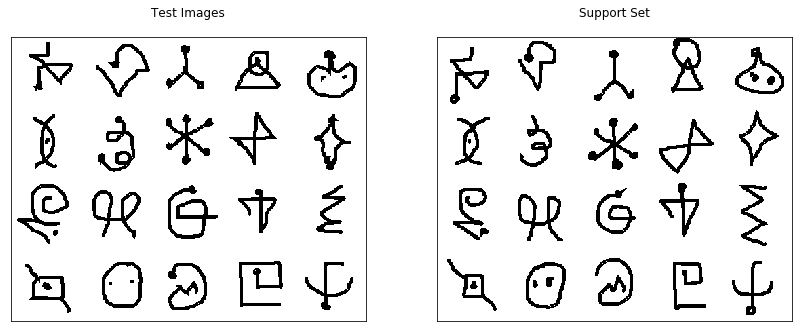

In [58]:
from data.data_utils import OneShotGenerator
from data.data_utils import plot_oneshot_task

TrnData = OneShotGenerator(X_trn, y_trn)
ValData = OneShotGenerator(X_trn, y_trn)
TstData = OneShotGenerator(X_evaluation, y_evaluation)

x_pairs, y_pairs = TrnData.generate_one_shot()

print('Below is a one-shot sample of characters from the {} alphabet.'.format(
                        y_pairs[0].Alphabet.iloc[0]) + \
      ' The sampled characters are at the same positions in both test and support plots.\n')
pairs = [x_pairs[0].reshape(20, 105, 105, 1), x_pairs[1].reshape(20, 105, 105, 1)]
# Note, the plot may fail sometimes since the training data has alphabets with less than
# 20 characters.  In this case, the OneShotGenerator samples test and support examples of
# the entire alphabet (from two randomly selected drawers).  The plot_oneshot (which was
# disigned to plot 20-way tasks) fails in this case.  Re-running the cell should generate
# a new sample that works.
plot_oneshot_task(pairs)

### Model Exploration: Nearest Neighbors

Nearest neighbors (NN) models provide a simple way of approaching this kind of task.  In this context, in order order to predict the class of a test image, such a model would:
 - Find the(or a group of) *closest* element(s) of the support set.
 - Use the class(es) of that(ose) element(s) to predict the class of the test image. 

NN models are simple to implent and often perform unexpectedly well given their simplicity.  Nevertheless, there are drawbacks that are immediately apparent for this task:
  - Given the one-shot nature of this problem, it would really only make sense to use the closest image in this context. Often, though, NN methods perform better when we can use more than one of the *closest* support set images to to classify the test image (as we can outvote mistakes).
  - As we can see by comparing the test and support images above, two examples of the same character often lie at different locations and have different scaling and orientation. This may conspire to guarantee that in comparing, for instance, euclidean distance between raw pixel values of images in order to find a *closest* match could easily result in returning the wrong example. 
  
Nevertheless, let's forge forth and try out a nearest neighbor model on some samples from the training set. 

In [8]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_nn(m=400, p=2, data=TrnData):
    accuracies = []
    for i in range(m):
        x_pairs, _ = data.generate_one_shot()
        n_way = x_pairs[0].shape[0]
        nn_clf = KNeighborsClassifier(n_neighbors=1, p=p)
        nn_clf.fit(x_pairs[1].reshape(n_way, -1), np.arange(n_way))
        preds = nn_clf.predict(x_pairs[0].reshape(n_way, -1))
        accuracies.append(np.mean(preds == np.arange(n_way)))
    return np.mean(accuracies)

for p in [1, 1.5, 2, 2.5, 3]:
    print('The estimated accuracy of 20-way one-shot by NN with Minkowski metric at' + \
          'a p value of {} is: {} \n'.format(p, evaluate_nn(m=50, p=p)))

The estimated accuracy of 20-way one-shot by NN with Minkowski metric ata p value of 1 is: 0.14996428571428574 

The estimated accuracy of 20-way one-shot by NN with Minkowski metric ata p value of 1.5 is: 0.2016281512605042 

The estimated accuracy of 20-way one-shot by NN with Minkowski metric ata p value of 2 is: 0.195422268907563 

The estimated accuracy of 20-way one-shot by NN with Minkowski metric ata p value of 2.5 is: 0.19484873949579837 

The estimated accuracy of 20-way one-shot by NN with Minkowski metric ata p value of 3 is: 0.16913865546218487 



In [9]:
for p in [1, 1.5, 2, 2.5, 3]:
    print('The estimated accuracy of 20-way one-shot by NN with Minkowski metric at' + \
          'a p value of {} is: {} \n'.format(p, evaluate_nn(m=50, p=p, data=ValData)))

The estimated accuracy of 20-way one-shot by NN with Minkowski metric ata p value of 1 is: 0.1595504201680672 

The estimated accuracy of 20-way one-shot by NN with Minkowski metric ata p value of 1.5 is: 0.1847857142857143 

The estimated accuracy of 20-way one-shot by NN with Minkowski metric ata p value of 2 is: 0.19376470588235292 

The estimated accuracy of 20-way one-shot by NN with Minkowski metric ata p value of 2.5 is: 0.19159453781512606 

The estimated accuracy of 20-way one-shot by NN with Minkowski metric ata p value of 3 is: 0.17163025210084037 



The following snippet of a post details how to pass your own metric to the nearest neighbors algorithm.  Seems that this should also work for KNearestNeighborsClassifier.
So, let's try this out with shape contexts.  

Nearest neighbors is quite underwhelming with Minkowski metric.  So let's do a blurb on shape contexts here and try getting things going with shape contexts along the lines of the example above.  We need to ammend things a bit here, because what we really want is the Jitendra image to edge method...  Also, need to have OpenCV going here... But let's try with what we have for now and then ammend things later.

In [239]:
from data.sc_utils import vec_image_to_shape_contexts, cosine_distances
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist, cosine

def chi_square_dists(sc1, sc2):
    n, m = sc1.shape
    a, b = sc1.reshape(n, 1, m), sc2.reshape(1, n, m)
    c, d = sc1.copy().reshape(n, 1, m), sc2.copy().reshape(1, n, m)
    # c[np.where((c==0) & (d==0))] = np.inf
    # d[np.where((c==0) & (d==0))] = np.inf
    f = c + d
    f[np.where(f==0)] = np.inf
    return (((a - b)**2) / f).sum(axis=-1) / 2

def full_costs(a1, a2, sc1, sc2, beta=0.3):
    return (1 - beta) * chi_square_dists(sc1, sc2) + beta * cosine_distances(a1, a2)
    # return (1 - beta) * cdist(sc1, sc2, 'canberra') + beta * cosine_distances(a1, a2)

def mydist(x, y, q=0.6):
    x_im = x.reshape(105, 105)
    y_im = x.reshape(105, 105)
    x_a, x_sc = vec_image_to_shape_contexts(x_im)
    y_a, y_sc = vec_image_to_shape_contexts(y_im)
    # print(x_sc.shape, y_sc.shape) # What about looking at dists on these
    costs = full_costs(x_a, y_a, x_sc, y_sc)
    # costs = chi_square_dists(x_sc, y_sc)
    i, pi = linear_sum_assignment(costs)
    good_inds = np.where(costs[i, pi] <= q)[0]
    return costs[i[good_inds], pi[good_inds]].sum()

In [15]:
mydist(pairs[0][1].reshape(-1), pairs[1][1].reshape(-1)), mydist(pairs[1][1].reshape(-1), pairs[0][1].reshape(-1))

(9.706526242217322, 9.314592877998258)

In [16]:
def predict(x_test, X_train, q=0.6):
    dists = []
    for pt in X_train:
        dists.append(mydist(x_test, pt, q=q) + \
                     mydist(pt, x_test, q=q))
    return np.argmin(dists), dists

# predict(pairs[0][0].reshape(-1), pairs[1].reshape(20, -1))

def return_preds(X_test, X_train, q=0.6):
    preds, pt_dists = [], []
    for pt in X_test:
        pred, dists = predict(pt, X_train=X_train, q=q)
        preds.append(pred)
        pt_dists.append(dists)
    return np.array(preds), np.stack(pt_dists)

In [17]:
preds, pt_dists = return_preds(pairs[0].reshape(20, -1), pairs[1].reshape(20, -1))

In [18]:
np.sum(preds == np.arange(20))

1

In [19]:
from sklearn.decomposition import KernelPCA, MiniBatchSparsePCA, PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [26]:
x_pairs, y_pairs = TrnData.generate_one_shot()

In [40]:
n_way = x_pairs[0].shape[0]

Transform = KernelPCA(n_components=15, kernel='rbf')
features = Transform.fit_transform(x_pairs[1].reshape(n_way, -1))

In [41]:
clf = KNeighborsClassifier(n_neighbors=1)

In [42]:
clf.fit(features, np.arange(20))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [43]:
test_features = Transform.transform(x_pairs[0].reshape(n_way, -1))
preds = clf.predict(test_features)

In [44]:
np.mean(preds == np.arange(20))

0.15

In [45]:
x_pairs[1].shape

(20, 105, 105)

In [46]:
x_pairs, y_pairs = TrnData.generate_one_shot()

In [47]:
n_way = x_pairs[0].shape[0]

clf = Pipeline([
            ('MSPCA', MiniBatchSparsePCA(n_components=15)),
            # ('TSVD', TruncatedSVD(n_components=25)),
            # ('KPCA', KernelPCA(n_components=25, kernel='rbf')), 
            ('NN', KNeighborsClassifier(n_neighbors=1))
        ])

clf.fit(x_pairs[1].reshape(n_way, -1), np.arange(n_way))
preds = clf.predict(x_pairs[0].reshape(n_way, -1))

np.mean(preds == np.arange(n_way))

0.05

In [50]:
def eval(clf, n_evals=50):
    accuracies = []
    for _ in range(n_evals):
        x_pairs, y_pairs = TrnData.generate_one_shot()
        n_way = x_pairs[0].shape[0]
        clf = Pipeline([
                    # ('MSPCA', MiniBatchSparsePCA(n_components=10)),
                    ('TSVD', TruncatedSVD(n_components=30)),
                    # ('KPCA', KernelPCA(n_components=25, kernel='rbf')), 
                    ('NN', KNeighborsClassifier(
                                        n_neighbors=1,
                                        p=2
                                    )
                        )
                ])
        clf.fit(x_pairs[1].reshape(n_way, -1), np.arange(n_way))
        preds = clf.predict(x_pairs[0].reshape(n_way, -1))
        accuracies.append(np.mean(preds == np.arange(n_way)))
    return np.mean(accuracies)

In [60]:
eval(clf)

0.20748319327731093

In [52]:
from imgaug import augmenters as iaa

The key to `iaa.Affine` lis to properly interpolate and fill in values (or zeros) that crop up when the image is rotated, translated, etc.  Looks like 0 is the standard value used which means there are a couple of ways to do this:
 - Reverse the representation of the images.  Looks like for Omniglot the background value is 0.  So when rotated and transformed, new values introduced are filled with 0 and this crops up as artefact.  If we normalize the images and set `im --> 1 - im` then the background will be zero and this problem should dissapear.
 - Change the background value to 1 by setting `cv=1` in the initialization of the image augmentor.  This also works well.
 - Set the `order` parameter to one of the option values.  This uses interpolation of the specified option to fill these values (such as Nearest-neighbor value or Bi-linear interpolation).  These seem like important options to be aware of in more complicated settings like ImageNet, etc.  

This about sums it up, and explains why the artefacts we were getting were cropping up.  Seems that the algorithms used here are vectorized and c-based because things are much faster using these options than my patchy loop based solution.  The fix was just to use `cv=1` which works well enough (the second solution would have been identical... I think).

The super sketchy loop based solution is based on the code that follows.  Definitely worth forgetting about and deferring to the solution outlined above. 

Appears that generating a whole bunch of random transformations of the images that sort of mimic the variations we might see in a sample of handwriting bumps up the accuracy a bit (but there's also quite a bit of variation in what we see)

Appears that we more or less keep increasing accuracy if we generate more transformations, but this is quite slow.  Maybe this has been vectorized in the other program or has to do with the size of the pictures.  

Also, appears that for a transformation to pass to nearest neighbors, representation in the top vectors learned by dictionary learning performs quite well.  Hard to tell though because it appears things have quite a bit of variance and it's slow to run. 

Lake et al. report an accuracy of 38.8% on the evaluation dataset by nearest neighbors with modified Hausdorff distance.  We were out to a fast start, butttttt this appears to be doing much better at the moment.  

What if we up our game by upping the number of transformations (and??? the number of NNs we consider...)

In [61]:
from sklearn.decomposition import MiniBatchDictionaryLearning

In [62]:
aug = iaa.Affine(scale=(0.8, 1.2), translate_px=(-5, 5), rotate=(-18, 18), cval=1)

In [63]:
# Revised version making use of the augment images functi
def augment_it_on_batch(x, y, n=5):
    n_way = x.shape[0]
    new_x = np.copy(x)
    for i in range(n):
        new_x = np.concatenate(
                (new_x, aug.augment_images(x).reshape(n_way, 105, 105))
                )
    return new_x, np.tile(y, n + 1)

In [64]:
# x_pairs, y_pairs = TrnData.generate_one_shot()
x_pairs, y_pairs = TstData.generate_one_shot()

In [65]:
n_reps = 200
n_way = x_pairs[1].shape[0]
x, y = augment_it_on_batch(x_pairs[1], np.arange(n_way), n=n_reps)

In [66]:
clf = Pipeline([
            ('MBDL', MiniBatchDictionaryLearning(n_components=20)),
            # ('TSVD', TruncatedSVD(n_components=20)),
            # ('KPCA', KernelPCA(n_components=25, kernel='rbf')), 
            ('NN', KNeighborsClassifier(n_neighbors=5))
        ])

clf.fit(x.reshape(n_way * (n_reps + 1), -1), y)
preds = clf.predict(x_pairs[0].reshape(n_way, -1))
np.mean(preds == np.arange(n_way))

0.2

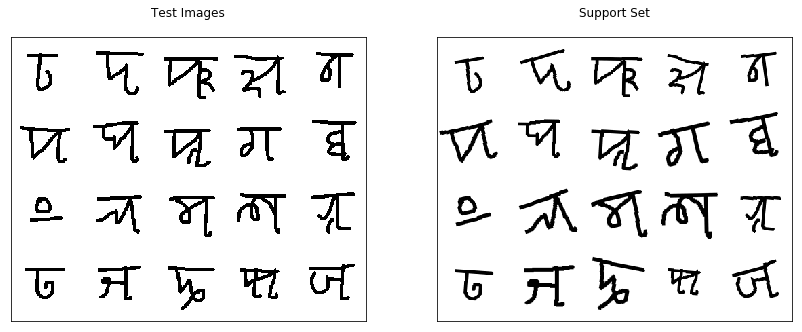

In [67]:
pairs = [x[:n_way].reshape(n_way, 105, 105, 1), x[4 * n_way:(5 * n_way)].reshape(n_way, 105, 105, 1)]
plot_oneshot_task(pairs)

In [68]:
n_trn = X_trn.shape[0]
X_trn.shape

(15424, 105, 105)

In [69]:
# Learn a dictionary from the training data that's good at
# representing these dictionaries
mbdlt = MiniBatchDictionaryLearning(20)
mbdlt.fit(X_trn.reshape(n_trn, -1))

MiniBatchDictionaryLearning(alpha=1, batch_size=3, dict_init=None,
              fit_algorithm='lars', n_components=20, n_iter=1000, n_jobs=1,
              random_state=None, shuffle=True, split_sign=False,
              transform_algorithm='omp', transform_alpha=None,
              transform_n_nonzero_coefs=None, verbose=False)

In [265]:
# x_pairs, y_pairs = TrnData.generate_one_shot()
x_pairs, y_pairs = ValData.generate_one_shot()

# Augment the training images with random affine
# transformations to mimic variations in handwritten
# characters
n_reps = 20
n_way = x_pairs[1].shape[0]
x, y = augment_it_on_batch(x_pairs[1], np.arange(n_way), n=n_reps)

In [266]:
# Classify by passing the characters through the 
# filter of the learned dictionary and then performing
# nearest neighbors.  Other models like decision trees
# etc.  
clf = KNeighborsClassifier(n_neighbors=5)

trn_features = mbdlt.transform(x.reshape(n_way * (n_reps + 1), -1))
tst_features = mbdlt.transform(x_pairs[0].reshape(n_way, -1))

clf.fit(trn_features, y)

preds = clf.predict(tst_features)
np.mean(preds == np.arange(n_way))

0.4117647058823529

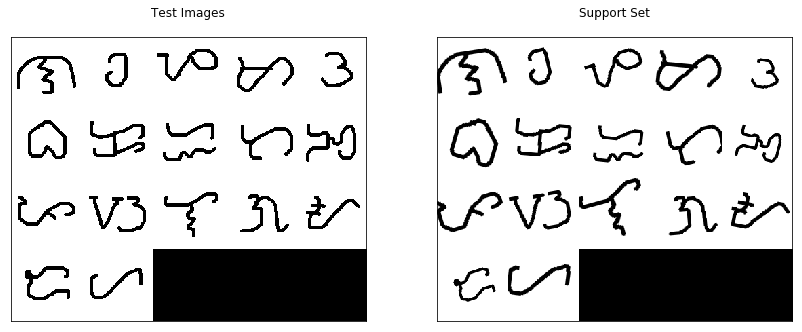

In [267]:
pairs = [x[:n_way].reshape(n_way, 105, 105, 1), x[4 * n_way:(5 * n_way)].reshape(n_way, 105, 105, 1)]
plot_oneshot_task(pairs)

In [268]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(trn_features, y)
clf.score(tst_features, np.arange(n_way))

0.11764705882352941

In [269]:
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier

clf = SVC(C=0.01, kernel='poly') #LinearSVC(C=0.01)
clf.fit(trn_features, y)
clf.score(tst_features, np.arange(n_way))

0.29411764705882354

The next cells are torturously slow, even just for classifying 20 points.  Would have been better if the images had been loaded as points and this wasn't part of the prediction process, which involves calculating the distances between many points...  But then we wouldn't have been able to use the sklearn's implementation.  

In [258]:
clf = KNeighborsClassifier(n_neighbors=1, metric=ModHausdorffDistance)

In [259]:
# clf.fit(x.reshape(n_way * (n_reps + 1), -1), y)
clf.fit(x_pairs[1].reshape(n_way, -1), np.arange(n_way))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function ModHausdorffDistance at 0x1f144bea0>,
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [260]:
clf.score(x_pairs[0].reshape(n_way, -1), np.arange(n_way))

0.1

Something I'd missed on the Lake application to this is that they transform the image to inked points (so the image is input as 1's = character points and 0's = blank space).  The images are then loaded as the coordinates of all the points that are 1.  

This is why the modified Hausdorff metric is applied (because each image is going to consist of a different number of points.  This also sort of explains why the modified Hausdorff metric is performing so poorly here... The metric makes sense if we're comparing distances between the points on two different characters; we're doing nothing of the sort when applying it to raw pixels.   

Any extensions of this to what we're doing?  Seems like if this method does o.k. 

Maybe I should just try running their script then.  

In [208]:
def eval(clf, data=ValData, n_evals=10):
    accuracies = []
    for _ in range(n_evals):
        # Generate tasks from validation data
        x_pairs, y_pairs = data.generate_one_shot()
        n_way = x_pairs[0].shape[0]
        x, y = augment_it_on_batch(x_pairs[1], np.arange(n_way), n=n_reps)
        
        # Transform the data
        trn_features = mbdlt.transform(x.reshape(n_way * (n_reps + 1), -1))
        tst_features = mbdlt.transform(x_pairs[0].reshape(n_way, -1))
        
        # Fit classifier to the training data, predict and
        # evaluate accuracy.
        clf.fit(trn_features, y)
        accuracies.append(clf.score(tst_features, np.arange(n_way)))
    return np.mean(accuracies)

In [297]:
import GPy
import GPyOpt

parameters = [{'name': 'C',      'type': 'continuous', 'domain': (0.0001, 10)},
              {'name': 'gamma',  'type': 'continuous', 'domain': (0.0001, 10)}]

def svr_val(params):
    params = params[0]
    clf = SVC(C=params[0], kernel='poly', gamma=params[1])
    return eval(clf)

opt = GPyOpt.methods.BayesianOptimization(f=svr_val, 
                                          domain=parameters,
                                          initial_design_numdata = 20,
                                          maximize=True,
                                          verbosity=True)  

In [316]:
opt.run_optimization(max_iter=50)

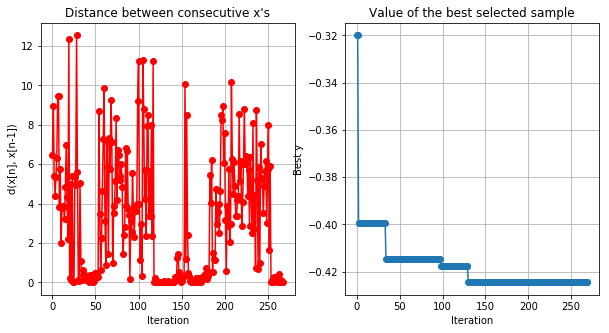

In [317]:
opt.plot_convergence()

In [314]:
best = np.argmin(opt.get_evaluations()[1])

In [315]:
opt.get_evaluations()[0][best]

array([0.17365271, 9.4150622 ])

In [306]:
clf = SVC(C=0.26, #8.2, #2.75, #40.7, 
          kernel='poly', 
          gamma=1.55) #5.5)
eval(clf, data=TstData, n_evals=200)

0.28025

In [296]:
clf = KNeighborsClassifier(n_neighbors=5)
eval(clf, data=TstData, n_evals=200)

0.25325000000000003

In [263]:
clf = KNeighborsClassifier(n_neighbors=1, metric=mydist)
clf.fit(x_pairs[1].reshape(n_way, -1), np.arange(n_way))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function mydist at 0x210db69d8>, metric_params=None,
           n_jobs=1, n_neighbors=1, p=2, weights='uniform')

In [264]:
clf.score(x_pairs[0].reshape(n_way, -1), np.arange(n_way))

0.05